## Estimation of memory to run PyGBe 

We want to know an estimation of the memory needs (GPU) to run bigger problem that what we've been running with PyGBe.

In this notebook we are showing some results on memory profiling obtained using **nvprof** (Nvidia profiler) for different problem sizes. 

We used a TESLA C2075 Nvidia GPU to make the runs.   


##### Estimation of number of elements for a 1M atoms protein.

Before estimating the amount of memory needed to run big problems ($>1M$), for completion, we will get an idea of how many elements (triangles) will have a mesh generated for this number of atoms. We will use the cases we've already run on and their density $d=2$ meshes generated using MSMS to do a linear regression and therefore estimate the number of elements needed. For simplicity and to have a first approach we used the meshes that doesn't involve cavities and stern layer.    

| Protein | Num. of atoms | Num. of elem. (d=2) |
|:-------:|:-------------:|:-------------------:|
|  1PGB   |      862      |         11696       |
|  1HEL   |      1323     |         21944       |
|  3BTK   |      4074     |         39432       |
|  1IGT   |      20147    |         225512      |


In [1]:
import numpy
from matplotlib import pyplot
from scipy.stats import linregress
%matplotlib inline

In [2]:
atoms = numpy.array([862,1323,4074,20147])
elements = numpy.array([11696,21944,39432,225512])

In [3]:
fit = numpy.polyfit(atoms, elements, 1)
fit_fn = numpy.poly1d(fit)

In [4]:
std_err = numpy.std(elements)
print(std_err)
fit_std_plus = fit_fn(atoms) + std_err
fit_std_minus = fit_fn(atoms) - std_err

87665.2426221


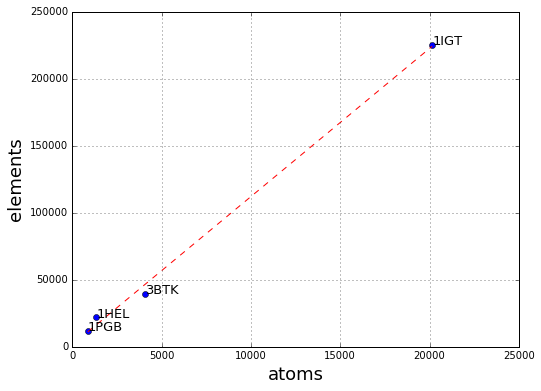

In [5]:
# Regression of number of elements according to number of atoms
pyplot.figure(figsize=(8,6))
pyplot.grid(True)

label = ['1PGB','1HEL','3BTK','1IGT']
for i, txt in enumerate(label):
    pyplot.annotate(txt, (atoms[i],elements[i]), rotation=0, fontsize=13)

pyplot.xlabel('atoms', fontsize=18)
pyplot.ylabel('elements', fontsize=18)
#pyplot.plot(atoms, fit_std_plus, '--r', label='$\sigma_{err}$')
#pyplot.plot(atoms,fit_std_minus, '--r')
#pyplot.annotate('$+\sigma_{err}$', (atoms[3],fit_std_plus[3]), fontsize=16)
#pyplot.annotate('$-\sigma_{err}$', (atoms[3],fit_std_minus[3]), fontsize=16);
pyplot.plot(atoms,elements, 'ob', atoms, fit_fn(atoms), '--r');



In [6]:
#estimate of elements for 1 and 3 million atoms according to the regression
elem_1Ma = fit_fn(1000000)
elem_dengue = fit_fn(1082160)
elem_3Ma = fit_fn(3000000)


print ('for 1M atoms: {:f} elements'.format(elem_1Ma))
print ('for dengue virus: {:f} elements'.format(elem_dengue))
print ('for 3M atoms: {:f} elements'.format(elem_3Ma))


for 1M atoms: 11060054.922977 elements
for dengue viruses: 11968613.972655 elements
for 3M atoms: 33176876.969673 elements


According to the regression, the amount of elements on a mesh of density $d=2$ on MSMS for a 1 million atoms protein and for a 3 million atoms protein are approximately 11 and 33 millions respectively. 

##### Estimation of memory 

We show the memory required to run `PyGBe` for all the cases of proteins we have. First we show for 1 iteration and then a progression for 1, 2, 4, 8, 16 and total iterations for each protein. 

**Iteration number 1**

| Protein | Mem HtoD (MB) | Mem DtoH (MB)|
|:-------:|:-------------:|:------------:|
|  1PGB   |      18.51    |     4.356    |
|  1HEL   |      24.84    |     4.796    |
|  3BTK   |      71.752   |     13.376   |
|  1IGT   |      639.406  |     70.796   |


In [8]:
HtoD_1it = numpy.array([18.51, 24.84, 71.752, 639.406])
DtoH_1it = numpy.array([4.356, 4.796, 13.376, 70.796])

In [9]:
fit_HtoD_1it = numpy.polyfit(atoms, HtoD_1it, 1)
fn_HtoD_1it = numpy.poly1d(fit_HtoD_1it)

fit_DtoH_1it = numpy.polyfit(atoms, DtoH_1it, 1)
fn_DtoH_1it = numpy.poly1d(fit_DtoH_1it)

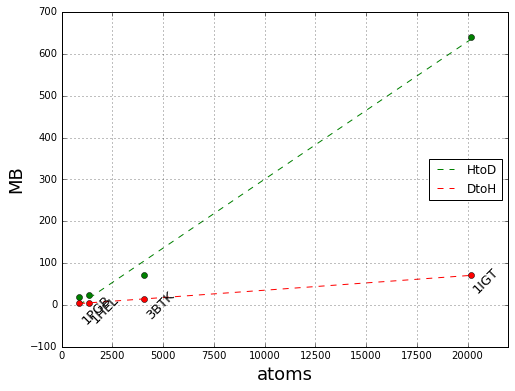

In [35]:
# Regression of number of elements according to number of atoms
pyplot.figure(figsize=(8,6))
pyplot.grid(True)

label = ['1PGB','1HEL','3BTK','1IGT']
for i, txt in enumerate(label):
    #pyplot.annotate(txt, (atoms[i],HtoD_1it[i]), rotation=45, fontsize=13)
    pyplot.annotate(txt, (atoms[i],DtoH_1it[i]), rotation=45, fontsize=13)


pyplot.xlim(0, 22000)
pyplot.xticks(numpy.arange(0, 22000, 2500))
pyplot.xlabel('atoms', fontsize=18)
pyplot.ylabel('MB', fontsize=18)
pyplot.plot(atoms,HtoD_1it, 'og')
pyplot.plot(atoms, fn_HtoD_1it(atoms), '--g', label= 'HtoD')
pyplot.plot(atoms,DtoH_1it, 'or')
pyplot.plot(atoms, fn_DtoH_1it(atoms), '--r', label= 'DtoH');
pyplot.legend(loc='center right');


In [54]:
fn_HtoD_1it(1000000)

32852.474339291228

In [7]:
from IPython.core.display import HTML
def css_styling():
    styles = open('styles/custom.css', 'r').read()
    return HTML(styles)
css_styling()